In [2]:
!pip install -U scikit-learn


### Import Necessary Packages

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import train and test dataset

In [5]:
train=pd.read_csv("/content/gdrive/MyDrive/MachineHack-work_hour_prediction_challenge/train.csv")
test=pd.read_csv("/content/gdrive/MyDrive/MachineHack-work_hour_prediction_challenge/test.csv")

### For easy pre-processing let's combine the train and test dataset.

In [6]:
full_data=pd.concat([train,test],axis=0)

#### The income column contains **>** and **<** symbols.If used directly in encoding it will raise a problem.So let's convert it as l50k and g50k.

In [7]:
mapv={' <=50K':'l50k',' >50K':'g50k'}
full_data['income']=full_data['income'].map(mapv)

### Import sklearn pre-processing module.

In [8]:
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [9]:
#Initialize scaler and label enoder.
scale=StandardScaler()

lbl=LabelEncoder()


#### Scale the numerical columns.

In [10]:
for i in ['age','capital-gain','capital-loss','fnlwgt']:
  full_data[i]=scale.fit_transform(full_data[[i]])

### Apply the Label encoding to categorical column.

In [11]:
for i in ['workclass','education','marital-status','occupation','relationship','race','native-country']:
  full_data[i]=lbl.fit_transform(full_data[[i]])

### Create and store one-hot encoding for sex and income column. 

In [12]:
oh=pd.get_dummies(full_data[['sex','income']])

### Join the one-hot encoded columns to actual dataframe.

In [13]:
full_data=pd.concat([full_data,oh],axis=1)

### Pre-processed data

In [14]:
full_data.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,sex_ Female,sex_ Male,income_g50k,income_l50k
0,0.958184,3,-0.696569,11,9,4,7,4,4,Male,-0.239333,-0.133809,44.0,38,l50k,0,1,0,1
1,2.758350,5,-0.338149,9,12,2,11,0,4,Male,2.887524,-0.133809,44.0,38,g50k,0,1,1,0
2,0.058100,3,0.839355,9,13,2,13,0,0,Male,-0.230197,-0.133809,57.0,38,g50k,0,1,1,0


### Create a group by age column numerical summary.

In [14]:
age_group=full_data.groupby(['relationship','race','sex','income'])['age'].agg({'min','mean','max'}).reset_index()

### Create a group by fnlwgt column numerical summary.

In [15]:
fnlwgt_group=full_data.groupby(['relationship','race','sex','income'])['fnlwgt'].agg({'min','mean','max'}).reset_index()

In [39]:
age_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   relationship  117 non-null    int64  
 1   race          117 non-null    int64  
 2   sex           117 non-null    object 
 3   income        117 non-null    object 
 4   min           117 non-null    float64
 5   mean          117 non-null    float64
 6   max           117 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 6.5+ KB


In [17]:
fnlwgt_group

,relationship,race,sex,income,min,max,mean
0,0,0,Female,g50k,-1.470011,0.646657,-0.347786
1,0,0,Female,l50k,-1.455007,0.876952,-0.460736
2,0,0,Male,g50k,-1.553739,3.006538,-0.102155
3,0,0,Male,l50k,-1.542502,2.830058,-0.143322
4,0,1,Female,g50k,-1.216837,2.187880,-0.215788
...,...,...,...,...,...,...,...
112,5,3,Male,l50k,-1.204344,1.070011,-0.067166
113,5,4,Female,g50k,-1.629061,2.751204,-0.215130
114,5,4,Female,l50k,-1.633519,3.004112,-0.102491
115,5,4,Male,g50k,-1.461179,2.751438,0.040099


### Change the column name

In [16]:
age_group=age_group.rename(columns={col:'age'+'_'+col for col in age_group.iloc[:,4:7]})

### Join the age summary data to the actual dataframe.

In [17]:
full_data=pd.merge(full_data,age_group,on=['relationship','race','sex','income'],how='left')

### Change the column name

In [18]:
fnlwgt_group=fnlwgt_group.rename(columns={col:'fnlwgt'+'_'+col for col in fnlwgt_group.iloc[:,4:7]})

### Join the fnlwgt summary data to the actual dataframe.

In [19]:
full_data=pd.merge(full_data,fnlwgt_group,on=['relationship','race','sex','income'],how='left')

### The final data look like this,

In [22]:
full_data.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,sex_ Female,sex_ Male,income_g50k,income_l50k,age_min,age_max,age_mean,fnlwgt_min,fnlwgt_max,fnlwgt_mean
0,0.958184,3,-0.696569,11,9,4,7,4,4,Male,-0.239333,-0.133809,44.0,38,l50k,0,1,0,1,-1.742066,3.883454,0.161565,-1.595838,4.501811,0.140415
1,2.758350,5,-0.338149,9,12,2,11,0,4,Male,2.887524,-0.133809,44.0,38,g50k,0,1,1,0,-1.517045,3.958461,0.461354,-1.651993,5.108968,-0.086402
2,0.058100,3,0.839355,9,13,2,13,0,0,Male,-0.230197,-0.133809,57.0,38,g50k,0,1,1,0,-1.442038,3.058378,0.389279,-1.553739,3.006538,-0.102155


### Create an negative value indicator column for capital-gain and capital-loss columns.

In [20]:
full_data['cap-gain-neg']=(full_data['capital-gain']<0).astype('int')
full_data['cap-loss-neg']=(full_data['capital-loss']<0).astype('int')

### Split the train and test data from combined dataframe.

In [21]:
train=full_data[full_data['hours-per-week'].notnull()]
test=full_data[full_data['hours-per-week'].isnull()]

### Create X and y Column.

In [22]:
X=train.iloc[:,np.r_[0:4,5:9,10,11,13,15:27]]
y=train['hours-per-week']

### Import xgboost library


In [23]:
import xgboost as xgb

#### Import optuna framework for hyperparameter optimization.

In [24]:
!pip install optuna

In [25]:
import optuna

### Import train_test_split

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Create XGBoost regressor model with optuna framework hyperparameter optimization.

In [112]:
def objective(trial):
  train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.15,random_state=42)
  param = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        #'lambda': trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        #'alpha': trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        'reg_lambda':trial.suggest_categorical('reg_lambda',[0.1, 1.0, 5.0, 10.0, 50.0, 100.0]),
        'eval_metric':'rmse',
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 0.001,1.0),
        'n_estimators': trial.suggest_categorical('n_estimators',[500]),
        'max_depth': trial.suggest_int('max_depth', 2,12),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
        }
  model=xgb.XGBRegressor(**param)
  model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
  preds = model.predict(test_x)
  rmse = mean_squared_error(test_y, preds,squared=False)
  return rmse


if __name__ == "__main__":
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)  

[I 2021-10-04 15:37:20,576] A new study created in memory with name: no-name-cef69165-0aaf-425c-814b-2f874fd403c3


[15:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:37:23,804] Trial 0 finished with value: 9.568781637823227 and parameters: {'reg_lambda': 10.0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.10468598509995006, 'n_estimators': 500, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 150}. Best is trial 0 with value: 9.568781637823227.


[15:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:37:26,008] Trial 1 finished with value: 9.61638766800896 and parameters: {'reg_lambda': 100.0, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.5521781910953454, 'n_estimators': 500, 'max_depth': 2, 'random_state': 48, 'min_child_weight': 169}. Best is trial 0 with value: 9.568781637823227.


[15:37:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:37:28,454] Trial 2 finished with value: 9.639972369971087 and parameters: {'reg_lambda': 50.0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.26677563404135307, 'n_estimators': 500, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 35}. Best is trial 0 with value: 9.568781637823227.


[15:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:37:38,140] Trial 3 finished with value: 9.571686765652023 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.016964294086155896, 'n_estimators': 500, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 107}. Best is trial 0 with value: 9.568781637823227.


[15:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:37:39,532] Trial 4 finished with value: 9.600253517077046 and parameters: {'reg_lambda': 100.0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.35101312667035056, 'n_estimators': 500, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 156}. Best is trial 0 with value: 9.568781637823227.


[15:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:37:43,462] Trial 5 finished with value: 9.656755051752546 and parameters: {'reg_lambda': 10.0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.5600553959069497, 'n_estimators': 500, 'max_depth': 12, 'random_state': 24, 'min_child_weight': 199}. Best is trial 0 with value: 9.568781637823227.


[15:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:37:48,404] Trial 6 finished with value: 9.577755218447942 and parameters: {'reg_lambda': 100.0, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.11778742760482278, 'n_estimators': 500, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 197}. Best is trial 0 with value: 9.568781637823227.


[15:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:37:52,883] Trial 7 finished with value: 9.836606202560223 and parameters: {'reg_lambda': 1.0, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.7447483170416535, 'n_estimators': 500, 'max_depth': 12, 'random_state': 48, 'min_child_weight': 81}. Best is trial 0 with value: 9.568781637823227.


[15:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:37:57,813] Trial 8 finished with value: 9.636997910508535 and parameters: {'reg_lambda': 100.0, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.5062185148570854, 'n_estimators': 500, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 292}. Best is trial 0 with value: 9.568781637823227.


[15:37:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:00,577] Trial 9 finished with value: 9.638093031123107 and parameters: {'reg_lambda': 1.0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.25443092569660947, 'n_estimators': 500, 'max_depth': 12, 'random_state': 48, 'min_child_weight': 252}. Best is trial 0 with value: 9.568781637823227.


[15:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:02,424] Trial 10 finished with value: 10.051717817262857 and parameters: {'reg_lambda': 10.0, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.9112709116935019, 'n_estimators': 500, 'max_depth': 6, 'random_state': 24, 'min_child_weight': 16}. Best is trial 0 with value: 9.568781637823227.


[15:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:07,675] Trial 11 finished with value: 9.588660697142362 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.03637259470182558, 'n_estimators': 500, 'max_depth': 8, 'random_state': 48, 'min_child_weight': 97}. Best is trial 0 with value: 9.568781637823227.


[15:38:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:14,862] Trial 12 finished with value: 9.55752234082176 and parameters: {'reg_lambda': 5.0, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.020245263713278283, 'n_estimators': 500, 'max_depth': 8, 'random_state': 48, 'min_child_weight': 113}. Best is trial 12 with value: 9.55752234082176.


[15:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:16,833] Trial 13 finished with value: 9.597397219374438 and parameters: {'reg_lambda': 5.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.1730438801188095, 'n_estimators': 500, 'max_depth': 4, 'random_state': 48, 'min_child_weight': 123}. Best is trial 12 with value: 9.55752234082176.


[15:38:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:20,337] Trial 14 finished with value: 9.63888835054381 and parameters: {'reg_lambda': 5.0, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.36813215691575385, 'n_estimators': 500, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 57}. Best is trial 12 with value: 9.55752234082176.


[15:38:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:24,397] Trial 15 finished with value: 9.59193607885431 and parameters: {'reg_lambda': 5.0, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.14114996819063488, 'n_estimators': 500, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 139}. Best is trial 12 with value: 9.55752234082176.


[15:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:26,214] Trial 16 finished with value: 9.581801430120228 and parameters: {'reg_lambda': 10.0, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.3749238671121523, 'n_estimators': 500, 'max_depth': 6, 'random_state': 48, 'min_child_weight': 216}. Best is trial 12 with value: 9.55752234082176.


[15:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:28,771] Trial 17 finished with value: 9.767541442806303 and parameters: {'reg_lambda': 50.0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.7076617506202928, 'n_estimators': 500, 'max_depth': 8, 'random_state': 48, 'min_child_weight': 69}. Best is trial 12 with value: 9.55752234082176.


[15:38:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:33,514] Trial 18 finished with value: 23.434824768855417 and parameters: {'reg_lambda': 10.0, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.0012571553319187072, 'n_estimators': 500, 'max_depth': 4, 'random_state': 24, 'min_child_weight': 160}. Best is trial 12 with value: 9.55752234082176.


[15:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:35,923] Trial 19 finished with value: 9.592843635105474 and parameters: {'reg_lambda': 5.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.24240989832841286, 'n_estimators': 500, 'max_depth': 6, 'random_state': 2020, 'min_child_weight': 244}. Best is trial 12 with value: 9.55752234082176.


[15:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:40,008] Trial 20 finished with value: 9.572856454698744 and parameters: {'reg_lambda': 10.0, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.10991137580789087, 'n_estimators': 500, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 125}. Best is trial 12 with value: 9.55752234082176.


[15:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:52,509] Trial 21 finished with value: 9.56894214739348 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.00997893926385062, 'n_estimators': 500, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 104}. Best is trial 12 with value: 9.55752234082176.


[15:38:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:56,419] Trial 22 finished with value: 9.575018409713248 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.07990571782485359, 'n_estimators': 500, 'max_depth': 10, 'random_state': 48, 'min_child_weight': 87}. Best is trial 12 with value: 9.55752234082176.


[15:38:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:38:58,543] Trial 23 finished with value: 9.614893676173038 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.22381759001174278, 'n_estimators': 500, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 53}. Best is trial 12 with value: 9.55752234082176.


[15:38:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:39:01,859] Trial 24 finished with value: 9.573773365826595 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.07791736840959575, 'n_estimators': 500, 'max_depth': 8, 'random_state': 48, 'min_child_weight': 184}. Best is trial 12 with value: 9.55752234082176.


[15:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:39:05,245] Trial 25 finished with value: 9.607309632949827 and parameters: {'reg_lambda': 5.0, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.16377553143687246, 'n_estimators': 500, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 133}. Best is trial 12 with value: 9.55752234082176.


[15:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:39:08,995] Trial 26 finished with value: 9.65968609205725 and parameters: {'reg_lambda': 50.0, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.32010584309181245, 'n_estimators': 500, 'max_depth': 10, 'random_state': 48, 'min_child_weight': 109}. Best is trial 12 with value: 9.55752234082176.


[15:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:39:12,596] Trial 27 finished with value: 9.954822806152457 and parameters: {'reg_lambda': 1.0, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.44125682465757116, 'n_estimators': 500, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 2}. Best is trial 12 with value: 9.55752234082176.


[15:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:39:25,044] Trial 28 finished with value: 9.559011794361863 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.0123682956180217, 'n_estimators': 500, 'max_depth': 10, 'random_state': 2020, 'min_child_weight': 145}. Best is trial 12 with value: 9.55752234082176.


[15:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:39:26,238] Trial 29 finished with value: 9.668533382786986 and parameters: {'reg_lambda': 10.0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.6014893339519825, 'n_estimators': 500, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 184}. Best is trial 12 with value: 9.55752234082176.


[15:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:39:29,435] Trial 30 finished with value: 9.585943341265375 and parameters: {'reg_lambda': 5.0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.1783601870724144, 'n_estimators': 500, 'max_depth': 10, 'random_state': 2020, 'min_child_weight': 150}. Best is trial 12 with value: 9.55752234082176.


[15:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:39:35,289] Trial 31 finished with value: 9.570645123669436 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.0692642812431251, 'n_estimators': 500, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 172}. Best is trial 12 with value: 9.55752234082176.


[15:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:39:48,741] Trial 32 finished with value: 9.561621278347758 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.011008747514058115, 'n_estimators': 500, 'max_depth': 8, 'random_state': 2020, 'min_child_weight': 111}. Best is trial 12 with value: 9.55752234082176.


[15:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:39:53,654] Trial 33 finished with value: 9.559435953147611 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.06342267482151942, 'n_estimators': 500, 'max_depth': 8, 'random_state': 2020, 'min_child_weight': 117}. Best is trial 12 with value: 9.55752234082176.


[15:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:39:58,444] Trial 34 finished with value: 9.570272380076588 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.055089374664581164, 'n_estimators': 500, 'max_depth': 8, 'random_state': 2020, 'min_child_weight': 120}. Best is trial 12 with value: 9.55752234082176.


[15:39:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:40:02,547] Trial 35 finished with value: 9.571362373800001 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.20217309174671275, 'n_estimators': 500, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 142}. Best is trial 12 with value: 9.55752234082176.


[15:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:40:05,148] Trial 36 finished with value: 9.608658239516233 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.2860065791038583, 'n_estimators': 500, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 80}. Best is trial 12 with value: 9.55752234082176.


[15:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:40:09,503] Trial 37 finished with value: 9.627795299190629 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.13157844891547432, 'n_estimators': 500, 'max_depth': 10, 'random_state': 2020, 'min_child_weight': 50}. Best is trial 12 with value: 9.55752234082176.


[15:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:40:22,954] Trial 38 finished with value: 9.559281168990369 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.011276695037204769, 'n_estimators': 500, 'max_depth': 8, 'random_state': 2020, 'min_child_weight': 114}. Best is trial 12 with value: 9.55752234082176.


[15:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:40:27,375] Trial 39 finished with value: 9.58061494638999 and parameters: {'reg_lambda': 100.0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.1078542035997751, 'n_estimators': 500, 'max_depth': 8, 'random_state': 2020, 'min_child_weight': 164}. Best is trial 12 with value: 9.55752234082176.


[15:40:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:40:29,521] Trial 40 finished with value: 9.67281961669648 and parameters: {'reg_lambda': 50.0, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.9150832013563148, 'n_estimators': 500, 'max_depth': 6, 'random_state': 2020, 'min_child_weight': 74}. Best is trial 12 with value: 9.55752234082176.


[15:40:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:40:45,403] Trial 41 finished with value: 10.128048910431962 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.004881740892953266, 'n_estimators': 500, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 113}. Best is trial 12 with value: 9.55752234082176.


[15:40:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:40:49,959] Trial 42 finished with value: 9.583924500377162 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.08008726010278316, 'n_estimators': 500, 'max_depth': 8, 'random_state': 2020, 'min_child_weight': 97}. Best is trial 12 with value: 9.55752234082176.


[15:40:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:40:54,824] Trial 43 finished with value: 9.554353057916941 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.04683325567808581, 'n_estimators': 500, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 136}. Best is trial 43 with value: 9.554353057916941.


[15:40:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:41:00,081] Trial 44 finished with value: 9.547606967659624 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.04753588425348945, 'n_estimators': 500, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 142}. Best is trial 44 with value: 9.547606967659624.


[15:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:41:03,277] Trial 45 finished with value: 9.58155096405566 and parameters: {'reg_lambda': 1.0, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.1317917808929854, 'n_estimators': 500, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 144}. Best is trial 44 with value: 9.547606967659624.


[15:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:41:10,316] Trial 46 finished with value: 9.570046449121229 and parameters: {'reg_lambda': 100.0, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.04078157172680426, 'n_estimators': 500, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 212}. Best is trial 44 with value: 9.547606967659624.


[15:41:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:41:13,000] Trial 47 finished with value: 9.565527702887112 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.19751539710618352, 'n_estimators': 500, 'max_depth': 6, 'random_state': 24, 'min_child_weight': 132}. Best is trial 44 with value: 9.547606967659624.


[15:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:41:15,511] Trial 48 finished with value: 9.761532961093339 and parameters: {'reg_lambda': 5.0, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.7747208301496255, 'n_estimators': 500, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 178}. Best is trial 44 with value: 9.547606967659624.


[15:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-10-04 15:41:19,712] Trial 49 finished with value: 9.585156661381234 and parameters: {'reg_lambda': 0.1, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.15150397957646028, 'n_estimators': 500, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 93}. Best is trial 44 with value: 9.547606967659624.


Number of finished trials: 50
Best trial: {'reg_lambda': 0.1, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.04753588425348945, 'n_estimators': 500, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 142}


In [113]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_random_state,params_reg_lambda,params_subsample,state
0,0,9.568782,2021-10-04 15:37:20.580618,2021-10-04 15:37:23.804087,0 days 00:00:03.223469,0.5,0.104686,5,150,500,48,10.0,0.5,COMPLETE
1,1,9.616388,2021-10-04 15:37:23.807187,2021-10-04 15:37:26.008108,0 days 00:00:02.200921,0.7,0.552178,2,169,500,48,100.0,0.8,COMPLETE
2,2,9.639972,2021-10-04 15:37:26.010513,2021-10-04 15:37:28.453869,0 days 00:00:02.443356,0.7,0.266776,5,35,500,48,50.0,0.7,COMPLETE
3,3,9.571687,2021-10-04 15:37:28.457331,2021-10-04 15:37:38.139511,0 days 00:00:09.682180,0.6,0.016964,9,107,500,48,0.1,1.0,COMPLETE
4,4,9.600254,2021-10-04 15:37:38.141879,2021-10-04 15:37:39.532264,0 days 00:00:01.390385,0.5,0.351013,3,156,500,2020,100.0,0.7,COMPLETE
5,5,9.656755,2021-10-04 15:37:39.534637,2021-10-04 15:37:43.462272,0 days 00:00:03.927635,0.9,0.560055,12,199,500,24,10.0,0.5,COMPLETE
6,6,9.577755,2021-10-04 15:37:43.465678,2021-10-04 15:37:48.404042,0 days 00:00:04.938364,0.8,0.117787,11,197,500,24,100.0,1.0,COMPLETE
7,7,9.836606,2021-10-04 15:37:48.406640,2021-10-04 15:37:52.883025,0 days 00:00:04.476385,0.8,0.744748,12,81,500,48,1.0,0.6,COMPLETE
8,8,9.636998,2021-10-04 15:37:52.885342,2021-10-04 15:37:57.813149,0 days 00:00:04.927807,1.0,0.506219,11,292,500,2020,100.0,0.8,COMPLETE
9,9,9.638093,2021-10-04 15:37:57.816248,2021-10-04 15:38:00.576574,0 days 00:00:02.760326,0.5,0.254431,12,252,500,48,1.0,0.5,COMPLETE


In [93]:
study.best_params

{'alpha': 1.3001207017027154e-07,
 'colsample_bytree': 0.8,
 'lambda': 0.05877022707100941,
 'learning_rate': 0.0020427007920456926,
 'max_depth': 10,
 'min_child_weight': 259,
 'random_state': 48,
 'subsample': 1.0}

### Visualizing the Optimization History - Explains the best score at each trails.

In [115]:
optuna.visualization.plot_optimization_history(study)

### Plot_parallel_coordinate: interactively visualizes the hyperparameters and scores

In [116]:
optuna.visualization.plot_parallel_coordinate(study)

### Visualizing High-dimensional Parameter Relationships

In [117]:
optuna.visualization.plot_slice(study)

### Visualizing Parameter Importances

In [118]:
optuna.visualization.plot_param_importances(study)

### Get the best parameters from optuna study

In [119]:
updated_params=study.best_params

### Create a model with new parameters

In [120]:
model = xgb.XGBRegressor(**updated_params,early_stopping_rounds=10)

### Fit the model

In [121]:
model.fit(X,y)

[15:53:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, early_stopping_rounds=10,
             learning_rate=0.04753588425348945, max_depth=7,
             min_child_weight=142, n_estimators=500, random_state=24,
             reg_lambda=0.1, subsample=0.8)

### Import shap for model explaination

In [40]:
!pip install shap

In [41]:
import shap

In [122]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

### Feature importance plot.

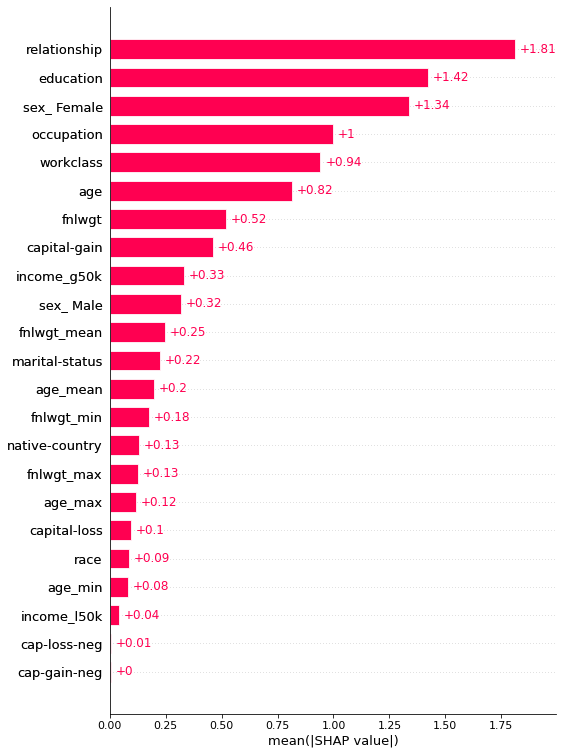

In [123]:
shap.plots.bar(shap_values,max_display=30)

### Top features impact the model

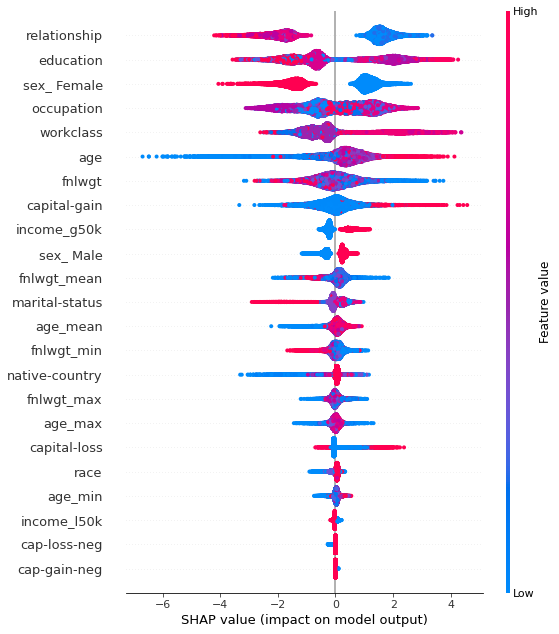

In [124]:
shap.plots.beeswarm(shap_values,max_display=30)

### Predict the test data

In [125]:
preds=model.predict(test.iloc[:,np.r_[0:4,5:9,10,11,13,15:27]])

### Store prediction in dataframe

In [126]:
res=pd.DataFrame({'hours-per-week':preds})

### Write the dataframe as csv file

In [127]:
res.to_csv("xgboost with optuna.csv",index=False)